In [34]:
suppressPackageStartupMessages({
    library(ComplexHeatmap)
    library(circlize)
    library(viridis)
    library(matrixStats)
    library(pheatmap)
    library(edgeR)
    library(limma)
    library(tidyverse)
    library(tidyr)
    library(RColorBrewer)
    library(Biobase)
    library(SingleCellExperiment)
    library(readr)
    library(SummarizedExperiment)
    library(zellkonverter)
    library(Seurat)
    library(SeuratDisk)
    library(DESeq2)
    library(ggrepel) 
    library(sva)
    library(tibble)
    library(cluster)
    library(dplyr)
    library(ggplot2)
    library(umap)
    library(patchwork)
    library(knitr)
    library(biomaRt)
    library(ggtext)
    library(org.Hs.eg.db)
    library(AnnotationDbi)
    library(clusterProfiler)
    library(gplots)
    library(gdata)
    library(maftools)
    library(fpc)
    library(reshape2)
    library(gridExtra)
    source('/mnt/beegfs/userdata/d_papakonstantinou/geomx/scripts/geomx_helper_functions.R')
})

group1_color = "#F2CA19"
group2_color = "#E11845"
custom_colors <- c("group1" = group1_color, "group2" = group2_color)

# Clinical

In [35]:
group1 = c("M2683", "M2644", "M578", "M2640", "M2650", "M844", "M2653", "M1121", "M077", "M2755", "M573", "M2686", "M2651", "M2725", "M2759", "M492", "M2687", "M2669", "MR695", "MR684", "M2086", "M2700", "MR836", "MR776", "MR702", "M2721", "M351", "M172", "M2715", "MR848", "M194")
group2 = c("M2666", "M2723", "M2746", "M157", "M2711", "M2753", "M2716", "M2760", "M2701", "M2747", "MR1096", "M2695", "M2738", "M167", "MR777", "M2681", "M2647", "M2671", "MR656", "M386", "M2722", "M2730", "M2713", "M2658", "M2703", "M2560", "M523", "M2494", "MR909", "M2708", "M2271", "M2761", "M2330", "M2312", "M2745", "M672", "M494", "M2733", "M2729", "M2754", "M2677", "M2758", "M2416", "MR513", "M2756", "M2709", "M2654", "M2710")
clinical = '/mnt/beegfs/userdata/d_papakonstantinou/wes/data/clinical_06_10_23.csv'
clinical <- read.csv(clinical, header = TRUE)
rownames(clinical) <- clinical$inclusion
#clinical <- assign_cluster(clinical,cols)
clinical$diagnosis_date <- as.Date(clinical$Diagnosis_Date,"%Y/%m/%d")
clinical$dodeath <- as.Date(clinical$dodeath,"%Y-%m-%d")
clinical$Birthdate <- as.Date(clinical$Birthdate,"%Y/%m/%d")
clinical$survival <- as.numeric(difftime(clinical$dodeath,clinical$diagnosis_date))
#clinical$Status <- ifelse(clinical$Is_dead == 'oui',1,0)
clinical$age_cat <- ifelse(clinical$Age > 60,"60+","60-")
# add metadata orgasation and technical platform
metadata = '/mnt/beegfs/userdata/d_papakonstantinou/wes/data/dataset.MyeloidDiversity.metadata_20230621164433.csv'
metadata <- read.csv(metadata, header = TRUE,sep=';')
metadata <- subset(metadata,protocol == 'mRNA-seq')
metadata$Alias.NOIGR <- as.numeric(gsub("[^0-9]", "", metadata$Alias.NOIGR))
metadata <- unique(metadata[,c("organisation","technicalPlatform","Alias.NOIGR")])
clinical$NIP <- as.numeric(gsub("[^0-9]", "", clinical$NIP))
clinical$technicalPlatform <- metadata$technicalPlatform[match(clinical$NIP, metadata$`Alias.NOIGR`)]
clinical$organisation <- metadata$organisation[match(clinical$NIP, metadata$`Alias.NOIGR`)]
names(clinical)[names(clinical)=="RNA"] <- "rna"
clinical <- clinical[order(as.Date(clinical$Biopsie_Date, format="%Y/%m/%d")),]
progression_time = as.numeric(abs(as.Date(clinical$diagnosis_date,"%Y-%m-%d") - as.Date(clinical$Biopsie_Date, "%Y/%m/%d")))
progression_time = findInterval(progression_time, seq(from = 1, to = max(progression_time),by= 365))
clinical$progression_time <- progression_time

############### load count matrix from file ###############
load('/mnt/beegfs/userdata/d_papakonstantinou/rna_seq/raw_counts.RData') #raw count matrix
###########################################################

cols <- colnames(count_matrix)
new_cols <- c()
for (col in cols) {
	if (grepl('A',col,fixed = TRUE)){
		if (grepl('MR',col,fixed = TRUE)){
			new_col <- gsub('A','',col)
			colnames(count_matrix)[colnames(count_matrix) == col] <- new_col
		} else {
			new_col <- gsub('A','MR',col)
			colnames(count_matrix)[colnames(count_matrix) == col] <- new_col
		}
	}
}

common <- intersect(clinical$inclusion,colnames(count_matrix))
diff1 <- setdiff(clinical$inclusion,colnames(count_matrix))
diff2 <- setdiff(colnames(count_matrix),clinical$inclusion)

####################### add mutational metadata #######################
clinical <- filter(clinical,inclusion %in% common)
count_matrix <- count_matrix[,common]
######################################################
clinical$Group <- NA
clinical$Group[rownames(clinical) %in% group1] <- "Group1"
clinical$Group[rownames(clinical) %in% group2] <- "Group2"
clinical$Biopsie_Date <- as.Date(clinical$Biopsie_Date, format="%Y/%m/%d")
clinical$Diagnosis_Date <- as.Date(clinical$Diagnosis_Date, format="%Y/%m/%d")
clinical$Days_Between <- clinical$Biopsie_Date - clinical$Diagnosis_Date
clinical$tumor_age <- interval(clinical$Diagnosis_Date, clinical$Biopsie_Date) %/% months(1)




# WES filtered data

In [36]:
maf = '/mnt/beegfs/userdata/d_papakonstantinou/wes/pdac_annotated_maf/pdac_filtered.maf' # filtered for driver genes
maf_unfiltered = '/mnt/beegfs/userdata/d_papakonstantinou/wes/outputs/oncotator_TvN_concatenated_filtered.tsv' # unfiltered for driver genes

wes_clinical = '/mnt/beegfs/userdata/d_papakonstantinou/wes/data/clinical_11_05_23.csv'

assign_cluster = function(dataframe,columns){
    dataframe <- dataframe[!is.na(dataframe$ICI),]
    rownames(dataframe) <- NULL
    treatments <- as.matrix(dataframe[,cols[-1]])
    dist_matrix <- daisy(treatments, metric = "manhattan")
    hc <- hclust(dist_matrix, method = "ward.D2")
    clusters <- cutree(hc, h = 2)
    dataframe$cluster <- clusters
    dataframe$cluster <- as.character(dataframe$cluster)
    table(dataframe$cluster)
    return(dataframe)
}

cols <- c("inclusion","Non.alkylating.chemo","Platinum.salts","TKIs","MAPK","PI3K.Akt" ,"DDR","Macrophages","ICI")

pdac.clin <- read.csv(wes_clinical, header = TRUE)
pdac.clin <- assign_cluster(pdac.clin,cols)
pdac.clin <- pdac.clin[!is.na(pdac.clin$ICI),]
names(pdac.clin)[names(pdac.clin)=="cluster"] <- "Treatment_Category"
rownames(pdac.clin) <- NULL
pdac.clin$diagnosis_date <- as.Date(pdac.clin$Diagnosis_Date,"%Y/%m/%d")
pdac.clin$dodeath <- as.Date(pdac.clin$dodeath,"%Y-%m-%d")
pdac.clin$Birthdate <- as.Date(pdac.clin$Birthdate,"%Y/%m/%d")
pdac.clin$survival <- as.numeric(difftime(pdac.clin$dodeath,pdac.clin$diagnosis_date))
pdac.clin$tumor_age <- as.numeric(clinical$tumor_age[match(pdac.clin$Tumor_Sample_Barcode, clinical$Tumor_Sample_Barcode)])
pdac.clin$Status <- ifelse(pdac.clin$Is_dead == 'oui',1,0)
pdac.clin$age_cat <- ifelse(pdac.clin$Age > 60,"60+","60-")
pdac.clin$Survival_Category <- ifelse(pdac.clin$survival > 1000,"1000+","1000-")
tumor_samples_ids <- unique(pdac.clin$Tumor_Sample_Barcode)
tumor_samples_ids <- tumor_samples_ids[tumor_samples_ids != ""]


Warning message in daisy(treatments, metric = "manhattan"):
"binary variable(s) 1, 2, 3, 4, 5, 6, 7, 8 treated as interval scaled"


[1] 27
[1] 44
-Processing clinical data
[1] "Class of survival:"
[1] "numeric"
[1] "First few values:"
[1]  3  7 12 30 17 30
[1] "Range:"
[1]  0 73
[1] "Any NAs?"
[1] 10
[1]  242  390  584 1106  725 1067
[1] "numeric"


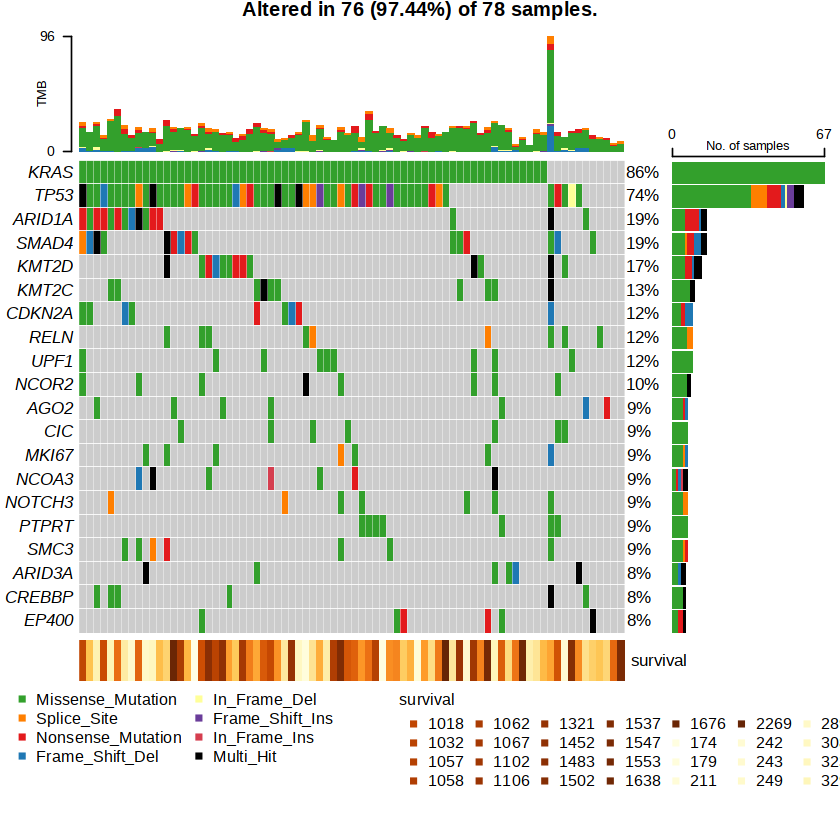

In [37]:
pdac.clin$survival <- as.numeric(pdac.clin$survival)
# pdac.clin$tumor_age <- as.numeric(pdac.clin$tumor_age)

pdac = read.maf(
    maf =maf,
    isTCGA = FALSE,
    verbose = FALSE, 
    clinicalData = pdac.clin
)

tsb_group1 <- clinical[clinical$Group == 'Group1',]$Tumor_Sample_Barcode
tsb_group1 <- tsb_group1[!is.na(tsb_group1) & tsb_group1 != ""]

tsb_group2 <- clinical[clinical$Group == 'Group2',]$Tumor_Sample_Barcode
tsb_group2 <- tsb_group2[!is.na(tsb_group2) & tsb_group2 != ""]


print(length(tsb_group1))
print(length(tsb_group2))


tsb <- clinical[clinical$inclusion %in% common,]$Tumor_Sample_Barcode

pdac <- subsetMaf(pdac,tsb =tumor_samples_ids)
maf.data <- pdac@data
maf.data <- maf.data %>%
mutate(t_vaf = t_t_alt_count / (t_t_alt_count + t_t_ref_count))
pdac@data <- maf.data

pdac.summary <- maftools::getSampleSummary(pdac)
#pdac.samples <- pdac.summary$Tumor_Sample_Barcode
pdac_samples <- unique(pdac@data$Tumor_Sample_Barcode)

vc_cols = RColorBrewer::brewer.pal(n = 8, name = 'Accent')
names(vc_cols) = c(
  'Frame_Shift_Del',
  'Missense_Mutation',
  'Nonsense_Mutation',
  'Multi_Hit',
  'Frame_Shift_Ins',
  'In_Frame_Ins',
  'Splice_Site',
  'In_Frame_Del'
)
# 1. Clean and verify the data
# Remove quotes and convert to numeric
pdac@clinical.data$survival <- as.numeric(gsub("['\"]", "", pdac@clinical.data$survival))
pdac@clinical.data$tumor_age <- as.numeric(gsub("['\"]", "", pdac@clinical.data$tumor_age))
survival_colors <- colorRampPalette(RColorBrewer::brewer.pal(9, "YlOrRd"))(100)
tumor_age_colors <- colorRampPalette(RColorBrewer::brewer.pal(11, "PRGn"))(100)    
# Verify the conversion
print("Class of survival:")
print(class(pdac@clinical.data$tumor_age))
print("First few values:")
print(head(pdac@clinical.data$tumor_age))
print("Range:")
print(range(pdac@clinical.data$tumor_age, na.rm = TRUE))
print("Any NAs?")
print(sum(is.na(pdac@clinical.data$tumor_age)))
# First verify our survival data
print(head(pdac@clinical.data$survival))
print(class(pdac@clinical.data$survival))

# Create a specific color gradient for survival
library(RColorBrewer)
oncoplot(maf = pdac, 
         clinicalFeatures = 'survival',
         removeNonMutated = FALSE,
#          annotationColor = list(survival = rev(brewer.pal(9, "YlOrRd")))
        )

-Processing clinical data
-Processing clinical data
[1] 27
[1] 44


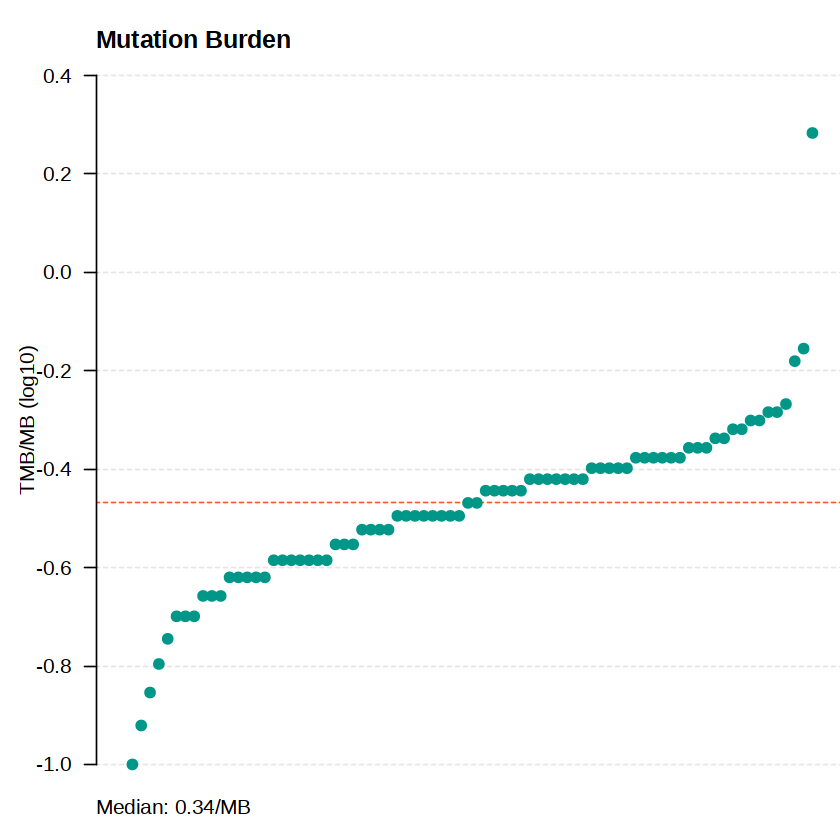

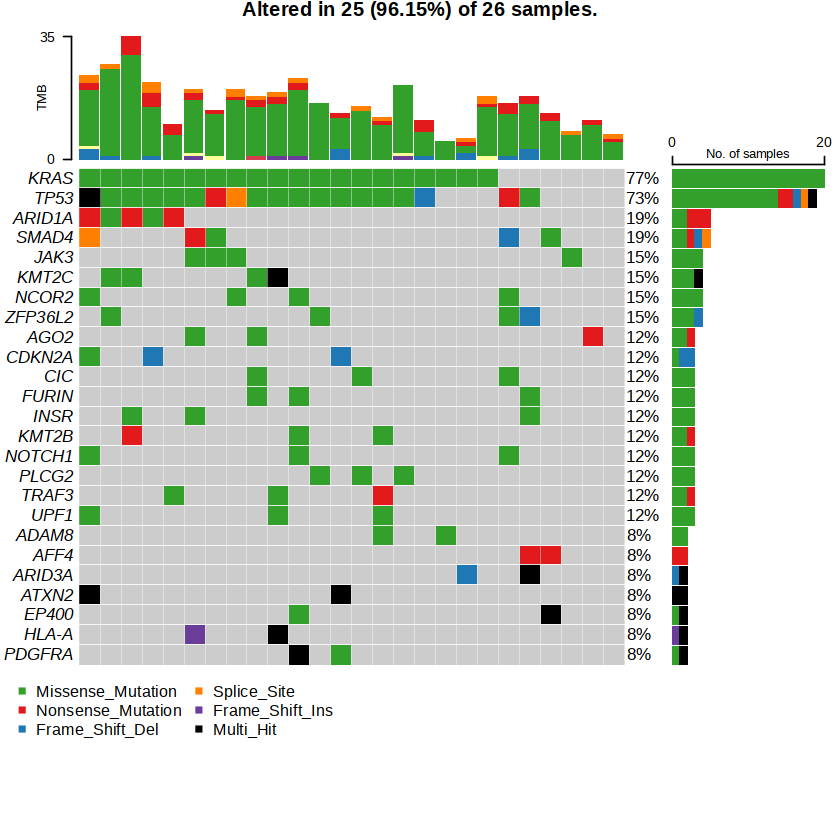

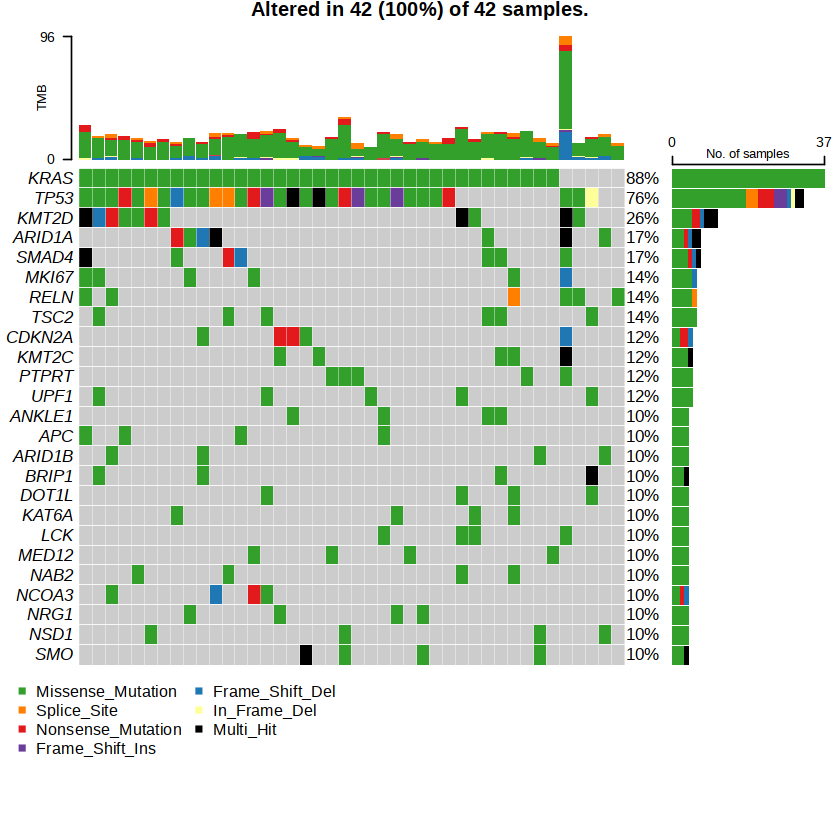

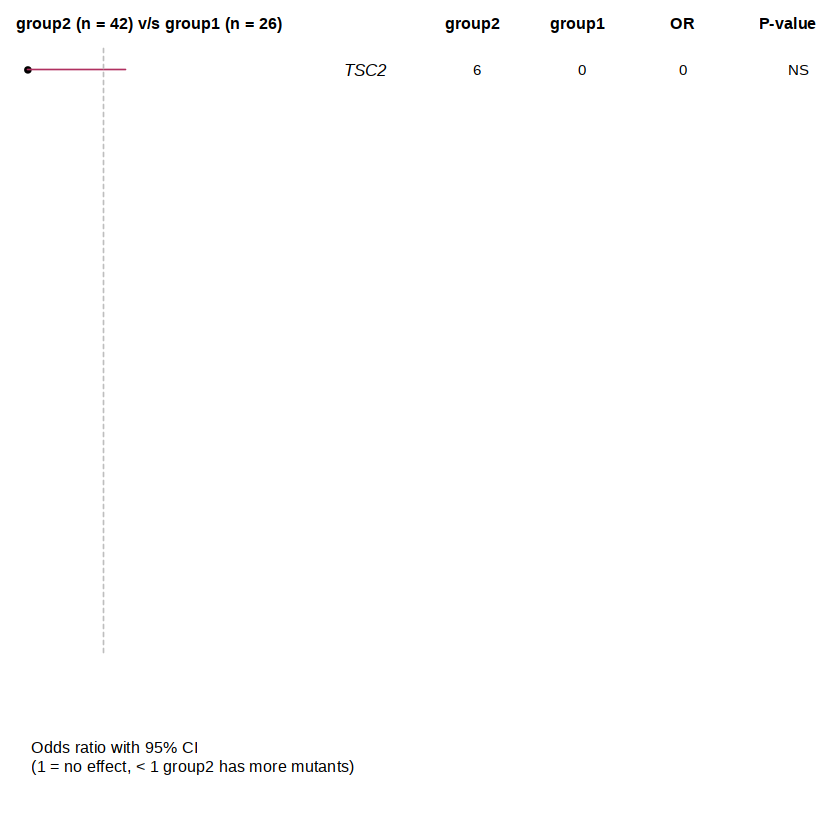

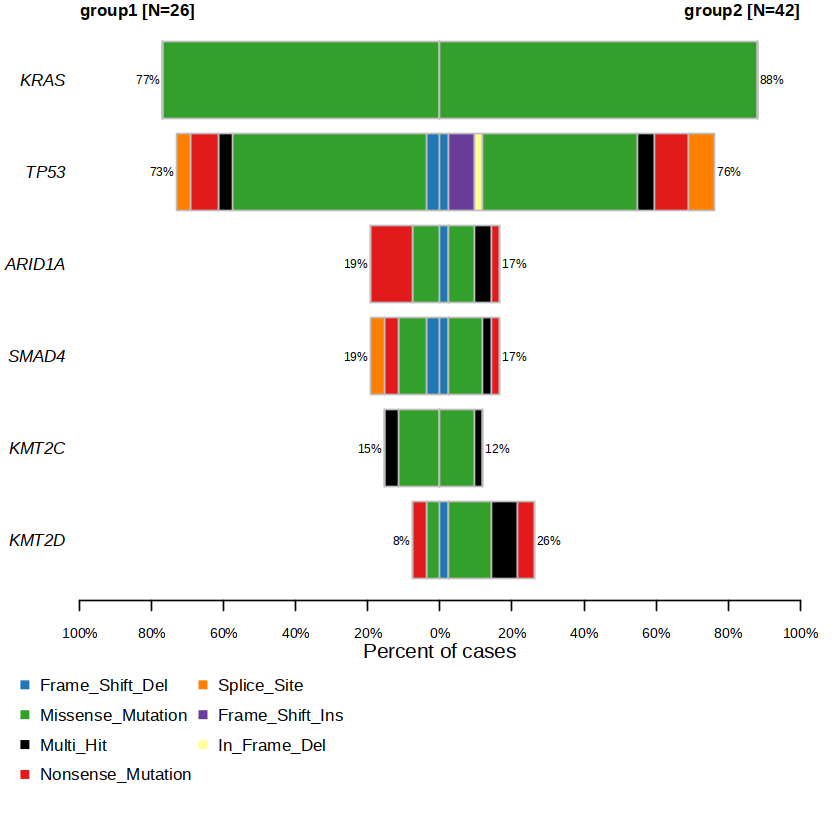

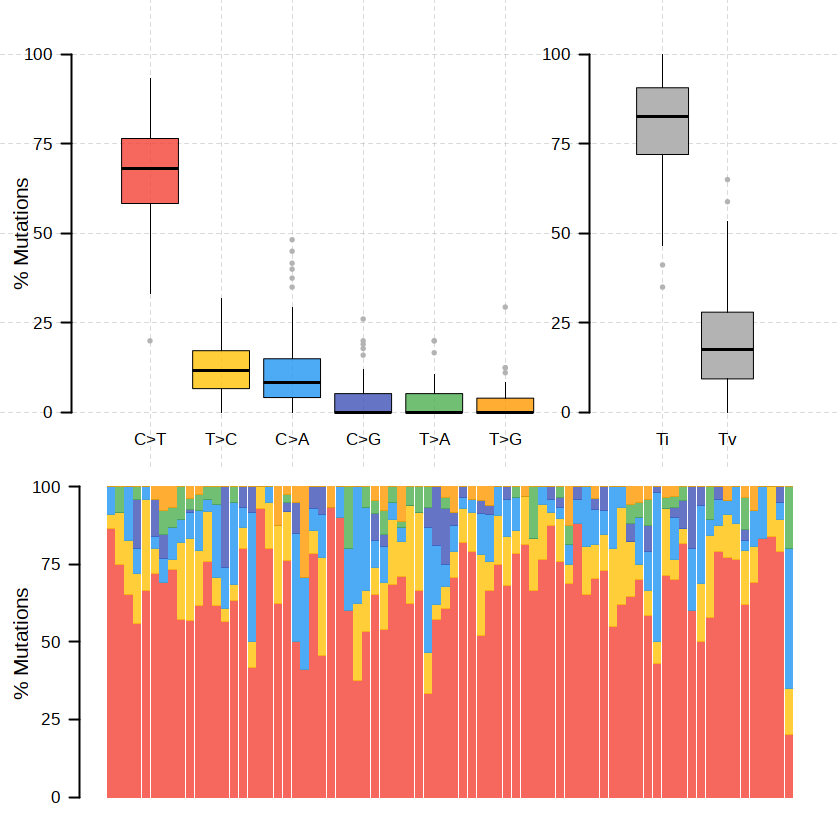

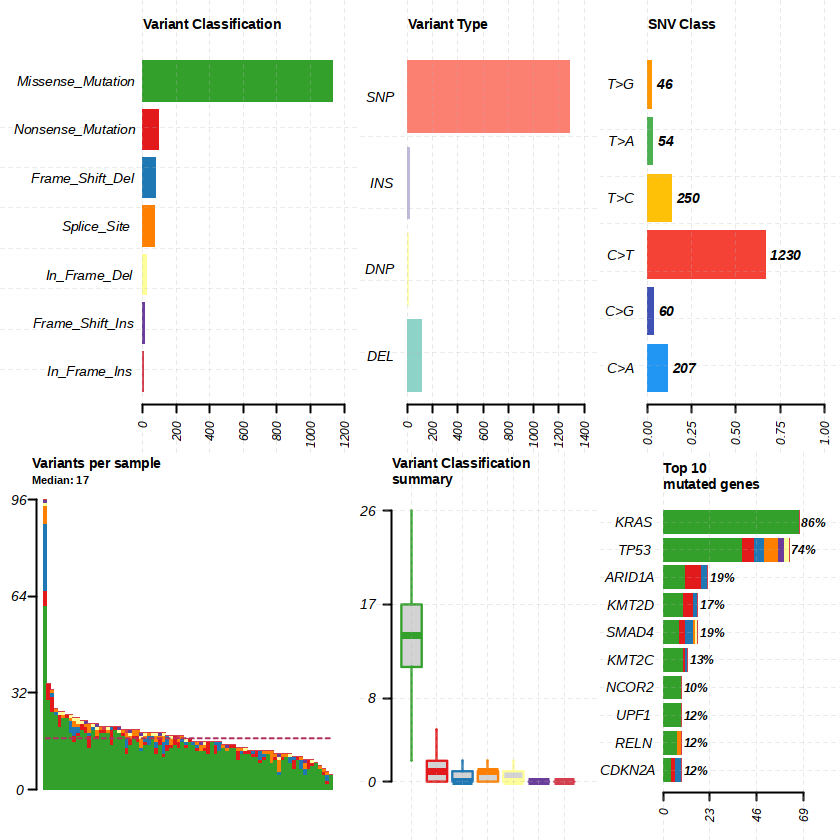

In [54]:
tmb_df <- maftools::tmb(pdac)
rownames(tmb_df) <-tmb_df$Tumor_Sample_Barcode
# oncoplot(maf = pdac, pathways = "sigpw", gene_mar = 8, fontSize = 0.6,removeNonMutated=F)

maf_group1 = subsetMaf(maf = pdac, tsb = tsb_group1)
maf_group2 = subsetMaf(maf = pdac, tsb = tsb_group2)

print(length(tsb_group1))
print(length(tsb_group2))
maf1_samples = unique(maf_group1@data$Tumor_Sample_Barcode)
maf2_samples = unique(maf_group2@data$Tumor_Sample_Barcode)

o1 <- oncoplot(maf_group1,removeNonMutated = FALSE,top =25)
o2 <- oncoplot(maf_group2,removeNonMutated = FALSE,top =25)

pt.vs.rt <- mafCompare(m1 = maf_group1, m2 = maf_group2, m1Name = 'group1', m2Name = 'group2', minMut = 5)

forestPlot(mafCompareRes = pt.vs.rt, pVal = 0.1)
coBarplot(m1 = maf_group1, m2 = maf_group2, m1Name = "group1", m2Name = "group2")

#lollipopPlot2(m1 = maf_group1, m2 = maf_group2, gene = 'TP53', m1_name = "group1", m2_name = "group2")
pdac.titv = titv(maf = pdac, plot = FALSE, useSyn = TRUE)
#plot titv summary
plotTiTv(res = pdac.titv )
plotmafSummary(maf = pdac, rmOutlier = TRUE, addStat = 'median', dashboard = TRUE, titvRaw = FALSE)

# WES unfiltered data

Warning message in daisy(treatments, metric = "manhattan"):
"binary variable(s) 1, 2, 3, 4, 5, 6, 7, 8 treated as interval scaled"


--Possible FLAGS among top ten genes:
  TTN
  SYNE1
  MUC16
  OBSCN
-Processing clinical data


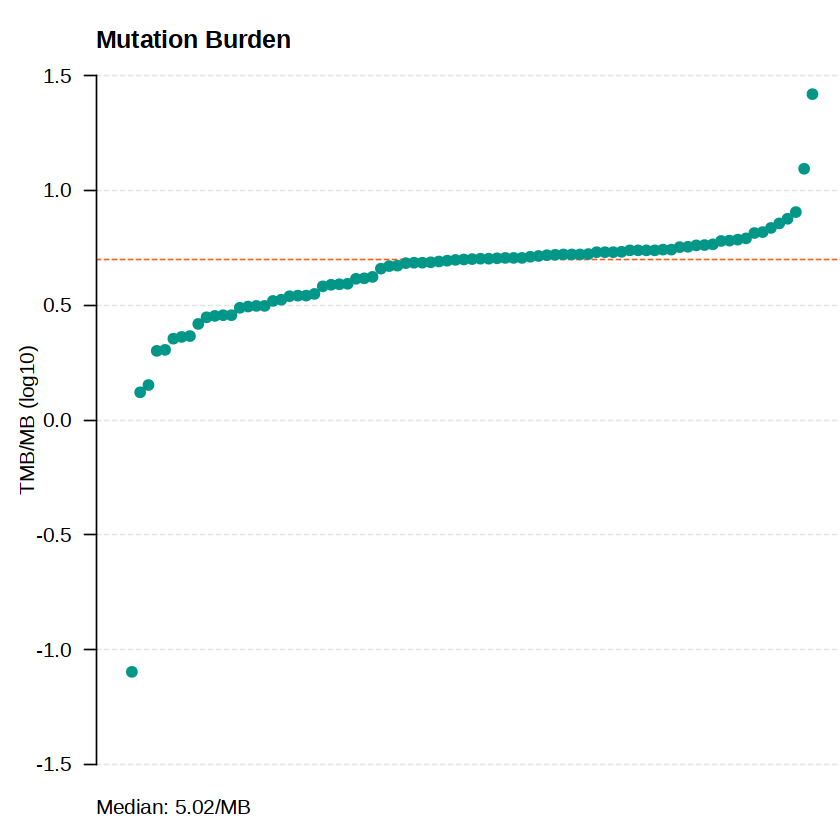

Drawing upto top 3 mutated pathways



                               Pathway     N n_affected_genes fraction_affected
                                <char> <int>            <int>             <num>
 1:                     MAPK_signaling     9                8         0.8888889
 2:                   Genome_integrity    14               13         0.9285714
 3:               Transcription_factor    39               30         0.7692308
 4:        Chromatin_histone_modifiers    15               12         0.8000000
 5:                              Other    22               16         0.7272727
 6:                    Other_signaling    28               19         0.6785714
 7:          Chromatin_SWI/SNF_complex     8               NA                NA
 8:                      RNA_abundance    15               12         0.8000000
 9:                      RTK_signaling    16               14         0.8750000
10:                    Chromatin_other    14               10         0.7142857
11:                     TGFB_signaling  

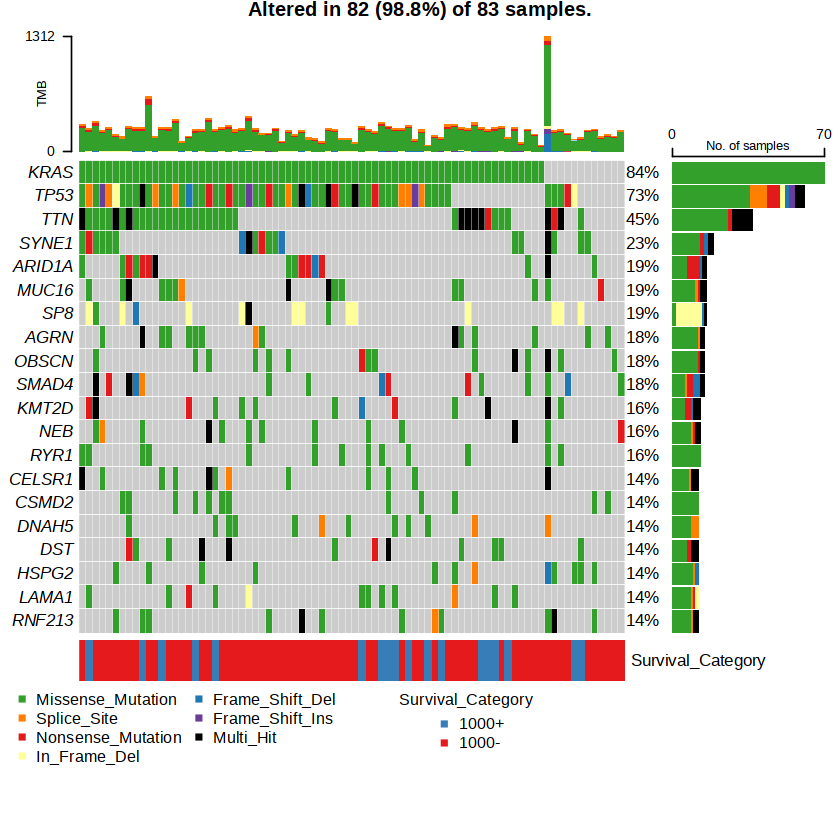

--Possible FLAGS among top ten genes:
  TTN
  SYNE1
  AHNAK
-Processing clinical data
--Possible FLAGS among top ten genes:
  TTN
  SYNE1
  OBSCN
  MUC5B
-Processing clinical data


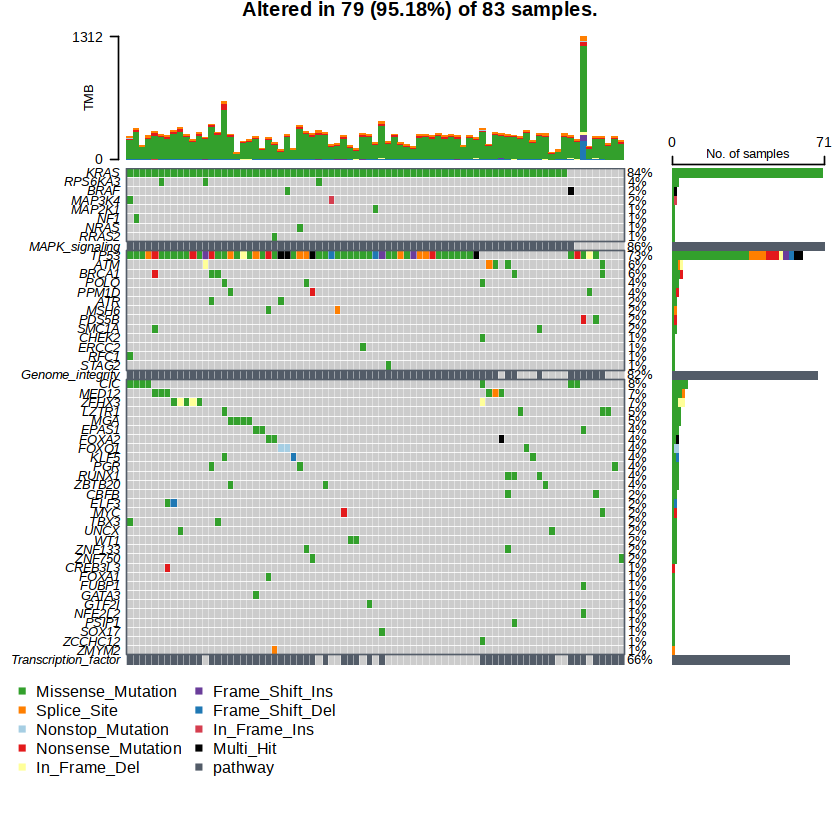

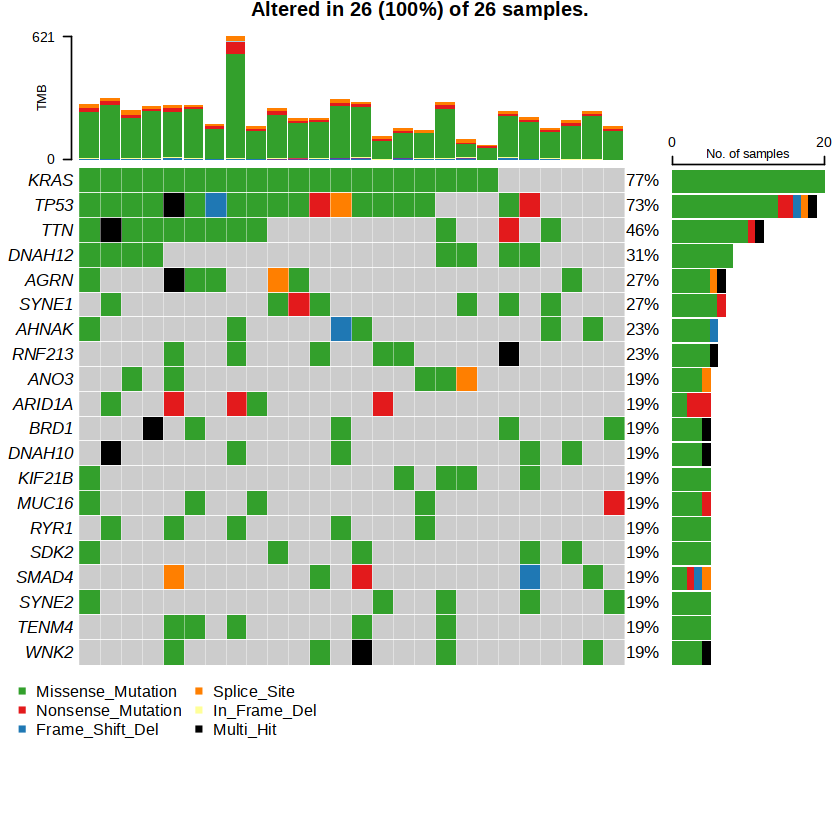

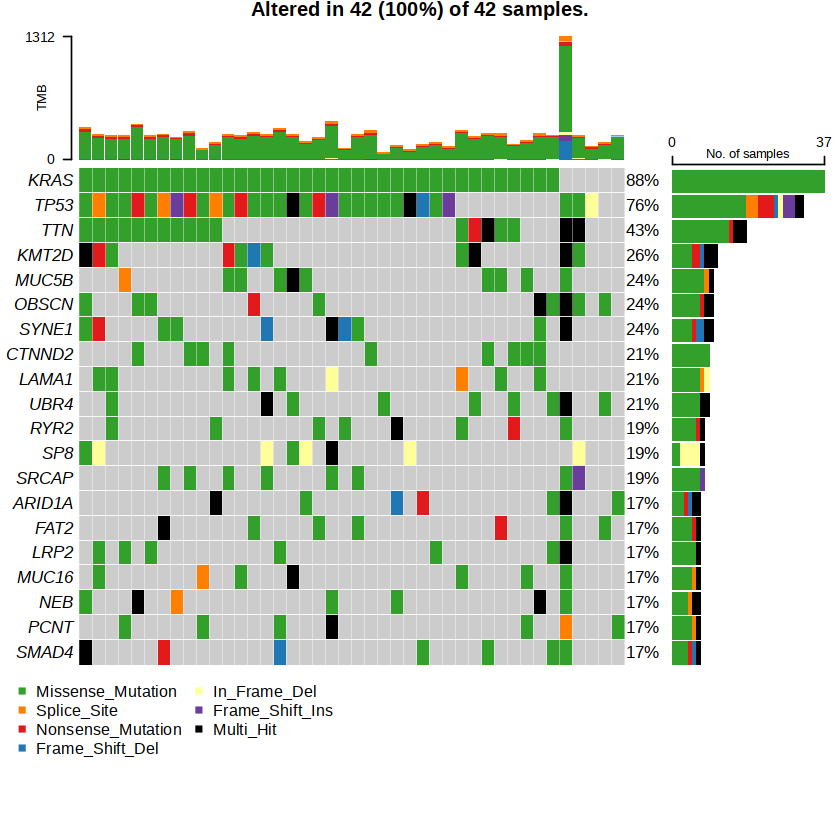

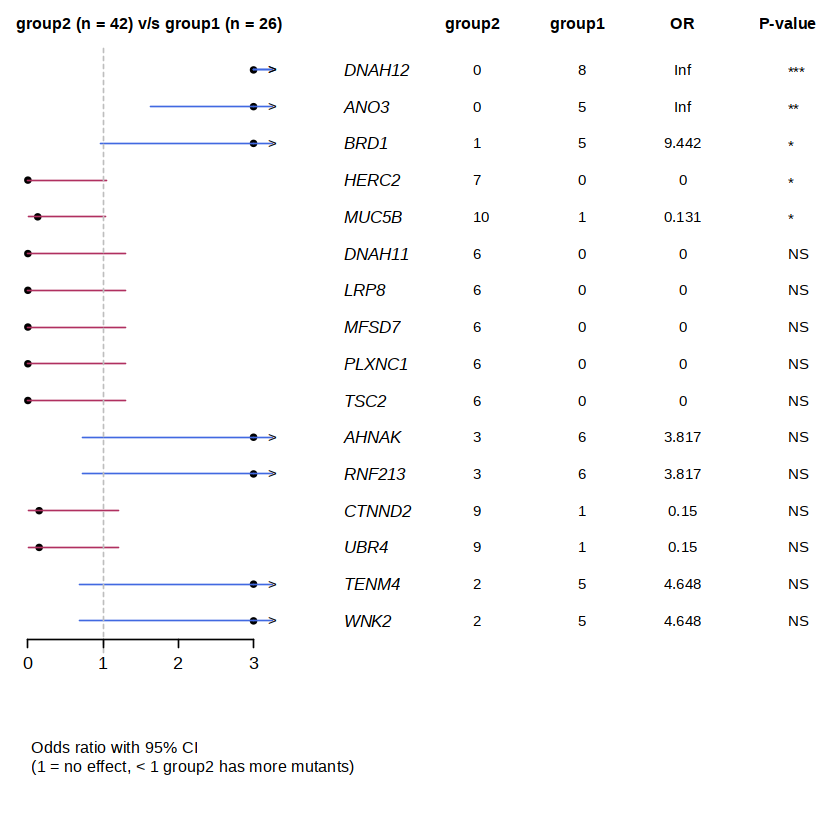

Gene: TP53

Assuming protein change information are stored under column Protein_Change. Use argument AACol to override if necessary.

8 transcripts available. Use arguments refSeqID or proteinID to manually specify tx name.



     HGNC    refseq.ID   protein.ID aa.length
   <char>       <char>       <char>     <num>
1:   TP53    NM_000546    NP_000537       393
2:   TP53 NM_001126112 NP_001119584       393
3:   TP53 NM_001126113 NP_001119585       346
4:   TP53 NM_001126114 NP_001119586       341
5:   TP53 NM_001126115 NP_001119587       261
6:   TP53 NM_001126116 NP_001119588       209
7:   TP53 NM_001126117 NP_001119589       214
8:   TP53 NM_001126118 NP_001119590       354


Using longer transcript NM_000546 for now.

Removed 1 mutations for which AA position was not available

Assuming protein change information are stored under column Protein_Change. Use argument AACol to override if necessary.

8 transcripts available. Use arguments refSeqID or proteinID to manually specify tx name.



     HGNC    refseq.ID   protein.ID aa.length
   <char>       <char>       <char>     <num>
1:   TP53    NM_000546    NP_000537       393
2:   TP53 NM_001126112 NP_001119584       393
3:   TP53 NM_001126113 NP_001119585       346
4:   TP53 NM_001126114 NP_001119586       341
5:   TP53 NM_001126115 NP_001119587       261
6:   TP53 NM_001126116 NP_001119588       209
7:   TP53 NM_001126117 NP_001119589       214
8:   TP53 NM_001126118 NP_001119590       354


Using longer transcript NM_000546 for now.

Removed 3 mutations for which AA position was not available



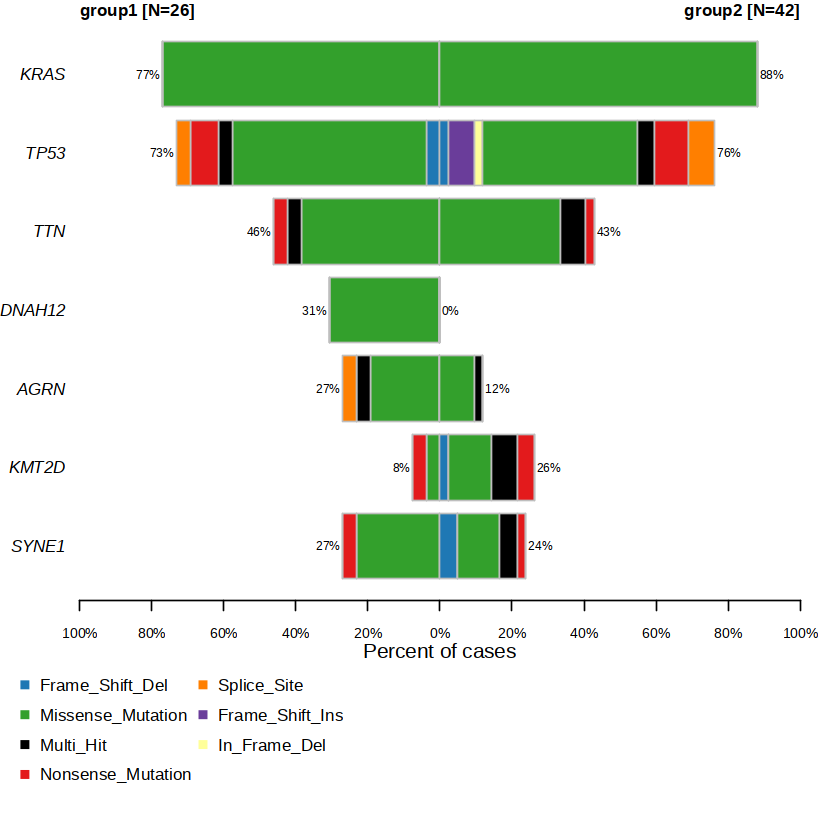

Warning message in oncodrive(maf = pdac, AACol = "Protein_Change", minMut = 5, pvalMethod = "zscore"):
"Oncodrive has been superseeded by OncodriveCLUSTL. See http://bg.upf.edu/group/projects/oncodrive-clust.php"
Estimating background scores from synonymous variants..



  |======================================================================| 100%

Not enough genes to build background. Using predefined values. (Mean = 0.279; SD = 0.13)

Estimating cluster scores from non-syn variants..



  |======================================================================| 100%

Comapring with background model and estimating p-values..

Done !



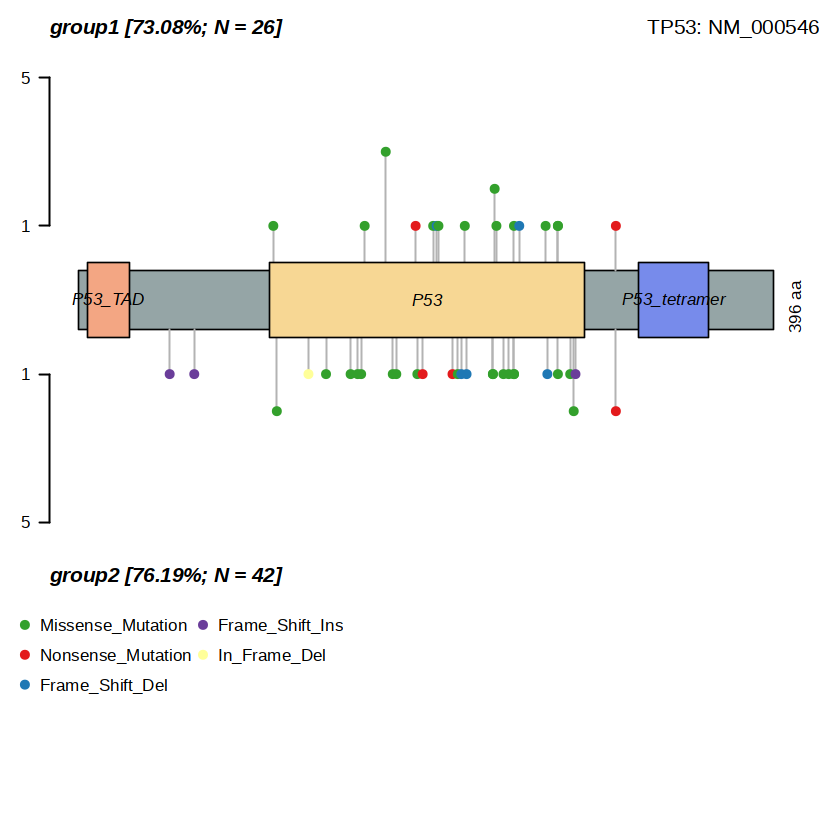

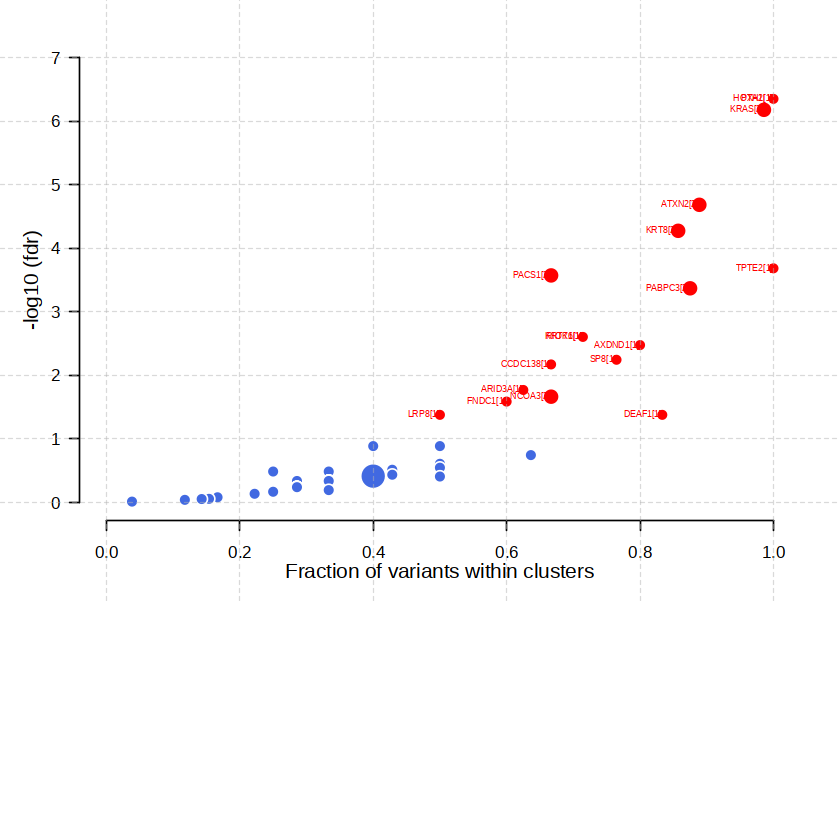

In [55]:
wes_clinical = '/mnt/beegfs/userdata/d_papakonstantinou/wes/data/clinical_11_05_23.csv'
maf_unfiltered = '/mnt/beegfs/userdata/d_papakonstantinou/wes/outputs/oncotator_TvN_concatenated_filtered.tsv' # unfiltered for driver genes

assign_cluster = function(dataframe,columns){
    dataframe <- dataframe[!is.na(dataframe$ICI),]
    rownames(dataframe) <- NULL
    treatments <- as.matrix(dataframe[,cols[-1]])
    dist_matrix <- daisy(treatments, metric = "manhattan")
    hc <- hclust(dist_matrix, method = "ward.D2")
    clusters <- cutree(hc, h = 2)
    dataframe$cluster <- clusters
    dataframe$cluster <- as.character(dataframe$cluster)
    table(dataframe$cluster)
    return(dataframe)
}

cols <- c("inclusion","Non.alkylating.chemo","Platinum.salts","TKIs","MAPK","PI3K.Akt" ,"DDR","Macrophages","ICI")

pdac.clin <- read.csv(wes_clinical, header = TRUE)
pdac.clin <- assign_cluster(pdac.clin,cols)
pdac.clin <- pdac.clin[!is.na(pdac.clin$ICI),]
names(pdac.clin)[names(pdac.clin)=="cluster"] <- "Treatment_Category"
rownames(pdac.clin) <- NULL
pdac.clin$diagnosis_date <- as.Date(pdac.clin$Diagnosis_Date,"%Y/%m/%d")
pdac.clin$dodeath <- as.Date(pdac.clin$dodeath,"%Y-%m-%d")
pdac.clin$Birthdate <- as.Date(pdac.clin$Birthdate,"%Y/%m/%d")
pdac.clin$survival <- as.numeric(difftime(pdac.clin$dodeath,pdac.clin$diagnosis_date))
pdac.clin$Status <- ifelse(pdac.clin$Is_dead == 'oui',1,0)
pdac.clin$age_cat <- ifelse(pdac.clin$Age > 60,"60+","60-")
pdac.clin$Survival_Category <- ifelse(pdac.clin$survival > 1000,"1000+","1000-")
tumor_samples_ids <- unique(pdac.clin$Tumor_Sample_Barcode)
tumor_samples_ids <- tumor_samples_ids[tumor_samples_ids != ""]

pdac = read.maf(
		maf =maf_unfiltered,
		isTCGA = FALSE,
		verbose = FALSE, 
		clinicalData = pdac.clin
		)

pdac <- subsetMaf(pdac ,tsb =tumor_samples_ids )
maf.data <- pdac@data
maf.data <- maf.data %>%
mutate(t_vaf = t_t_alt_count / (t_t_alt_count + t_t_ref_count))
pdac@data <- maf.data

tmb_df <- maftools::tmb(pdac)
rownames(tmb_df) <-tmb_df$Tumor_Sample_Barcode

pdac.summary <-  maftools::getSampleSummary(pdac)
#pdac.samples <- pdac.summary$Tumor_Sample_Barcode
pdac_samples <- unique(pdac@data$Tumor_Sample_Barcode)
#cat(paste(pdac.samples,collapse='\n')) print all the samples in the MAF file
kras_pos <- unique(subset(pdac@data,Hugo_Symbol == 'KRAS')$Tumor_Sample_Barcode)
kras_neg <- setdiff(pdac_samples,kras_pos)

tp53_pos <- unique(subset(pdac@data,Hugo_Symbol == 'TP53')$Tumor_Sample_Barcode)
tp53_neg <- setdiff(pdac_samples,tp53_pos)


oncoplot(maf = pdac, clinicalFeatures = 'Survival_Category')
oncoplot(maf = pdac, pathways = "sigpw", gene_mar = 8, fontSize = 0.6)

# tsb_group1 <- clinical[clinical$Group == 'Group1',]$Tumor_Sample_Barcode
# tsb_group1 <- tsb_group1[!is.na(tsb_group1) & tsb_group1 != ""]
# tsb_group2 <- clinical[clinical$Group == 'Group2',]$Tumor_Sample_Barcode
# tsb_group2 <- tsb_group2[!is.na(tsb_group2) & tsb_group2 != ""]

maf_group1 = subsetMaf(maf = pdac, tsb = maf1_samples)
maf_group2 = subsetMaf(maf = pdac, tsb = maf2_samples)

o1 <- oncoplot(maf_group1)
o2 <- oncoplot(maf_group2)

pt.vs.rt <- mafCompare(m1 = maf_group1, m2 = maf_group2, m1Name = 'group1', m2Name = 'group2', minMut = 5)

forestPlot(mafCompareRes = pt.vs.rt, pVal = 0.1)
coBarplot(m1 = maf_group1, m2 = maf_group2, m1Name = "group1", m2Name = "group2")

lollipopPlot2(m1 = maf_group1, m2 = maf_group2, gene = 'TP53', m1_name = "group1", m2_name = "group2")

pdac.sig = oncodrive(maf = pdac, AACol = 'Protein_Change', minMut = 5, pvalMethod = 'zscore')
plotOncodrive(res = pdac.sig, fdrCutOff = 0.1, useFraction = TRUE, labelSize = 0.5)

-Processing Gistic files..
--Processing amp_genes.conf_90.txt
--Processing del_genes.conf_90.txt
--Processing scores.gistic
--Summarizing by samples


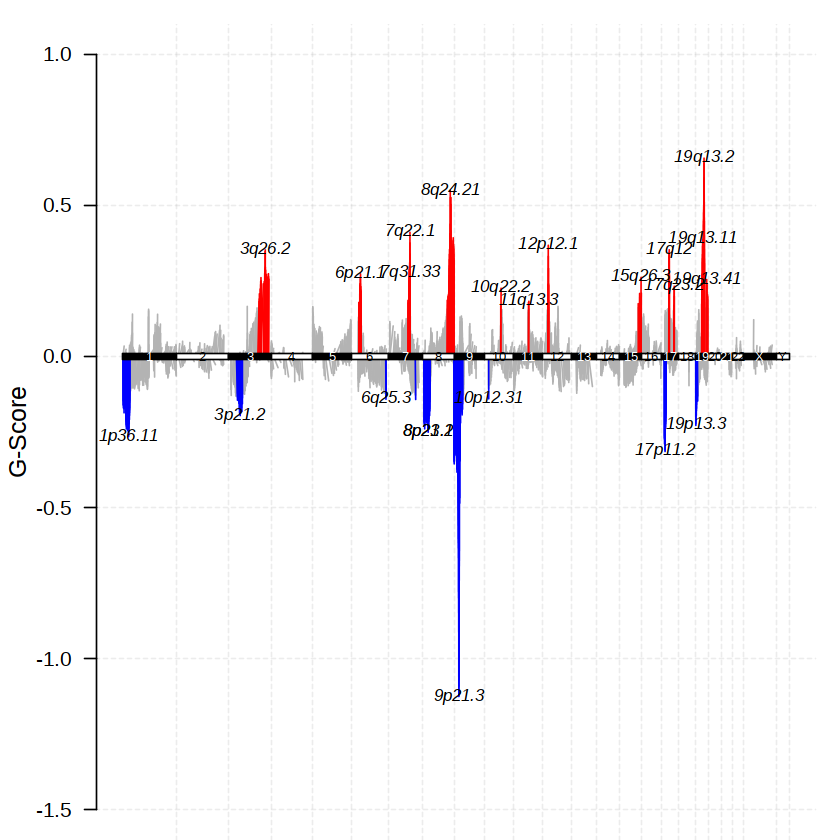

In [9]:
pdac.gistic = readGistic(gisticAllLesionsFile   = "/mnt/beegfs/userdata/d_papakonstantinou/wes/cnv_analysis/all_samples/all_lesions.conf_90.txt",      
                         gisticAmpGenesFile     = "/mnt/beegfs/userdata/d_papakonstantinou/wes/cnv_analysis/all_samples/amp_genes.conf_90.txt",
                         gisticDelGenesFile     = "/mnt/beegfs/userdata/d_papakonstantinou/wes/cnv_analysis/all_samples/del_genes.conf_90.txt",
                         gisticScoresFile       = "/mnt/beegfs/userdata/d_papakonstantinou/wes/cnv_analysis/all_samples/scores.gistic",
                         isTCGA = FALSE
                        )

gisticChromPlot(gistic = pdac.gistic, markBands = "all")


-Processing Gistic files..
--Processing amp_genes.conf_90.txt
--Processing del_genes.conf_90.txt
--Processing scores.gistic
--Summarizing by samples


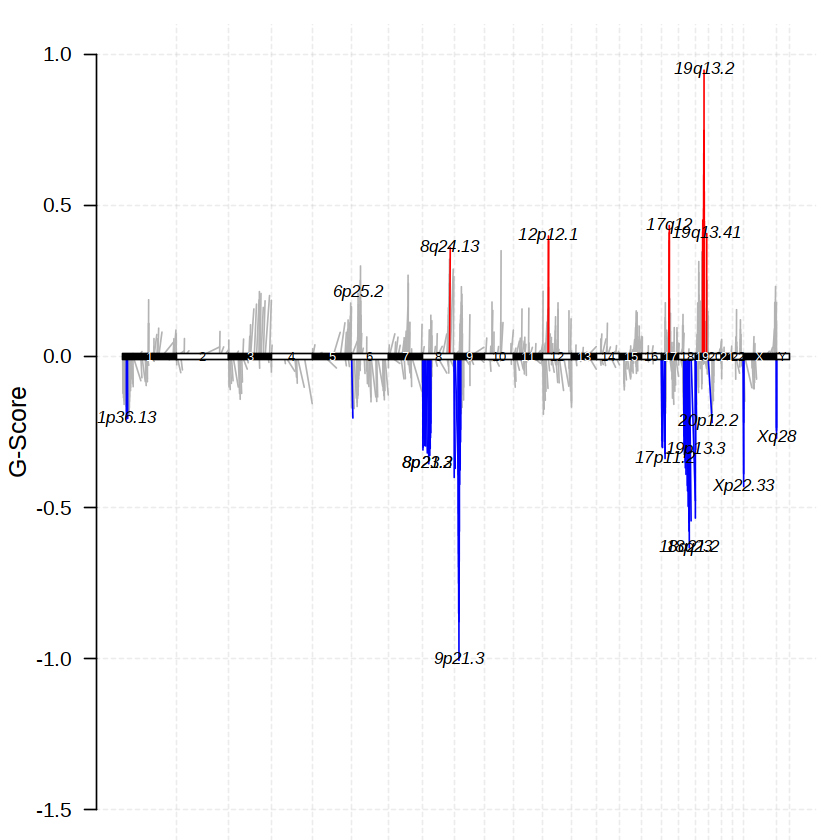

In [10]:
pdac.gistic.group1 = readGistic(gisticAllLesionsFile   = "/mnt/beegfs/userdata/d_papakonstantinou/wes/cnv_analysis/group1_samples/all_lesions.conf_90.txt",      
                         gisticAmpGenesFile     = "/mnt/beegfs/userdata/d_papakonstantinou/wes/cnv_analysis/group1_samples/amp_genes.conf_90.txt",
                         gisticDelGenesFile     = "/mnt/beegfs/userdata/d_papakonstantinou/wes/cnv_analysis/group1_samples/del_genes.conf_90.txt",
                         gisticScoresFile       = "/mnt/beegfs/userdata/d_papakonstantinou/wes/cnv_analysis/group1_samples/scores.gistic",
                         isTCGA = FALSE
                        )

gisticChromPlot(gistic = pdac.gistic.group1, markBands = "all")

-Processing Gistic files..
--Processing amp_genes.conf_90.txt
--Processing del_genes.conf_90.txt
--Processing scores.gistic
--Summarizing by samples


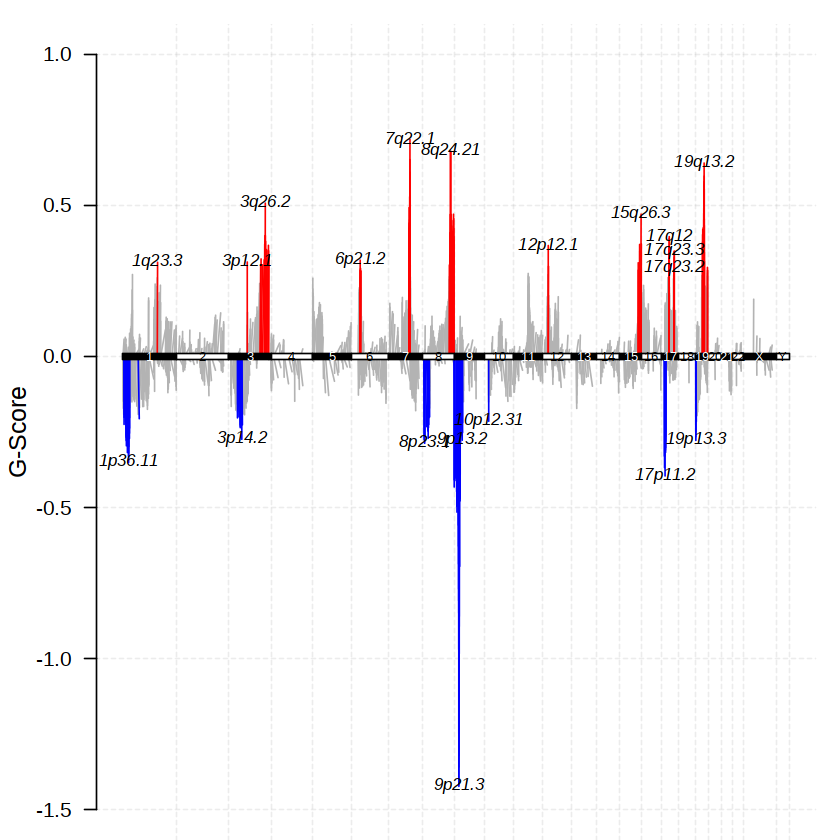

In [11]:
pdac.gistic.group2 = readGistic(gisticAllLesionsFile   = "/mnt/beegfs/userdata/d_papakonstantinou/wes/cnv_analysis/group2_samples/all_lesions.conf_90.txt",      
                         gisticAmpGenesFile     = "/mnt/beegfs/userdata/d_papakonstantinou/wes/cnv_analysis/group2_samples/amp_genes.conf_90.txt",
                         gisticDelGenesFile     = "/mnt/beegfs/userdata/d_papakonstantinou/wes/cnv_analysis/group2_samples/del_genes.conf_90.txt",
                         gisticScoresFile       = "/mnt/beegfs/userdata/d_papakonstantinou/wes/cnv_analysis/group2_samples/scores.gistic",
                         isTCGA = FALSE
                        )

gisticChromPlot(gistic = pdac.gistic.group2, markBands = "all")

In [12]:
# print(paste(tumor_samples_ids, collapse = ","))